In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [14]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

#### Bibile Monaragala LSTM

In [186]:
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [187]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000019
1   2019-01-02      0.000019
2   2019-01-03      0.000028
3   2019-01-04      0.000037
4   2019-01-05     -0.000018


In [188]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, -1])  # Assuming target is the last column
    return np.array(X), np.array(y)

sequence_length = 5# Adjust sequence length as necessary

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  
    Bidirectional(LSTM(units=50)),  
    Dropout(0.2),  
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 34s 298ms/step - loss: 0.8541 - mean_squared_error: 0.8541 - val_loss: 0.8850 - val_mean_squared_error: 0.8850
Epoch 2/100
37/37 [==============================] - 5s 125ms/step - loss: 0.7963 - mean_squared_error: 0.7963 - val_loss: 0.8746 - val_mean_squared_error: 0.8746
Epoch 3/100
37/37 [==============================] - 5s 132ms/step - loss: 0.7904 - mean_squared_error: 0.7904 - val_loss: 0.8568 - val_mean_squared_error: 0.8568
Epoch 4/100
37/37 [==============================] - 7s 182ms/step - loss: 0.8031 - mean_squared_error: 0.8031 - val_loss: 0.8721 - val_mean_squared_error: 0.8721
Epoch 5/100
37/37 [==============================] - 5s 133ms/step - loss: 0.8091 - mean_squared_error: 0.8091 - val_loss: 0.8761 - val_mean_squared_error: 0.8761
Epoch 6/100
37/37 [==============================] - 5s 131ms/step - loss: 0.8126 - mean_squared_error: 0.8126 - val_loss: 1.0070 - val_mean_squared_error: 1.0070
Epoch 7/100
37/37 [==

37/37 [==============================] - 5s 134ms/step - loss: 0.7917 - mean_squared_error: 0.7917 - val_loss: 0.8669 - val_mean_squared_error: 0.8669
Epoch 52/100
37/37 [==============================] - 5s 140ms/step - loss: 0.7877 - mean_squared_error: 0.7877 - val_loss: 0.8742 - val_mean_squared_error: 0.8742
Epoch 53/100
37/37 [==============================] - 5s 137ms/step - loss: 0.7838 - mean_squared_error: 0.7838 - val_loss: 0.8564 - val_mean_squared_error: 0.8564
Epoch 54/100
37/37 [==============================] - 5s 135ms/step - loss: 0.7893 - mean_squared_error: 0.7893 - val_loss: 0.8549 - val_mean_squared_error: 0.8549
Epoch 55/100
37/37 [==============================] - 5s 139ms/step - loss: 0.7865 - mean_squared_error: 0.7865 - val_loss: 0.8616 - val_mean_squared_error: 0.8616
Epoch 56/100
37/37 [==============================] - 5s 138ms/step - loss: 0.7902 - mean_squared_error: 0.7902 - val_loss: 0.8632 - val_mean_squared_error: 0.8632
Epoch 57/100
37/37 [=========

12/12 [==============================] - 6s 35ms/step


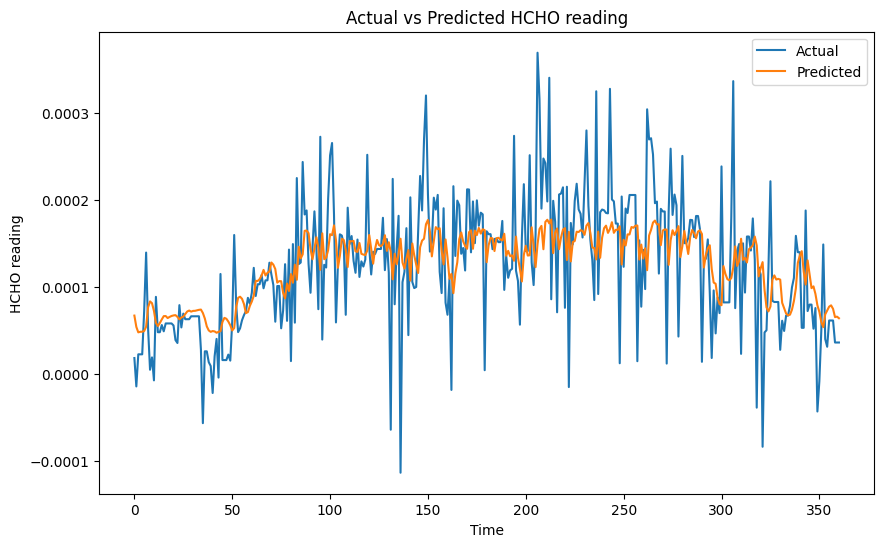

In [189]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 36ms/step


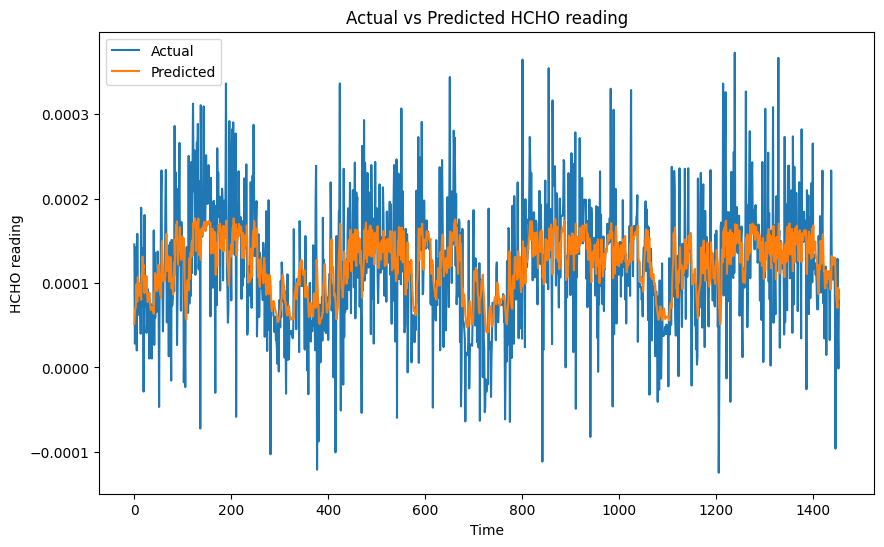

In [190]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 35ms/step


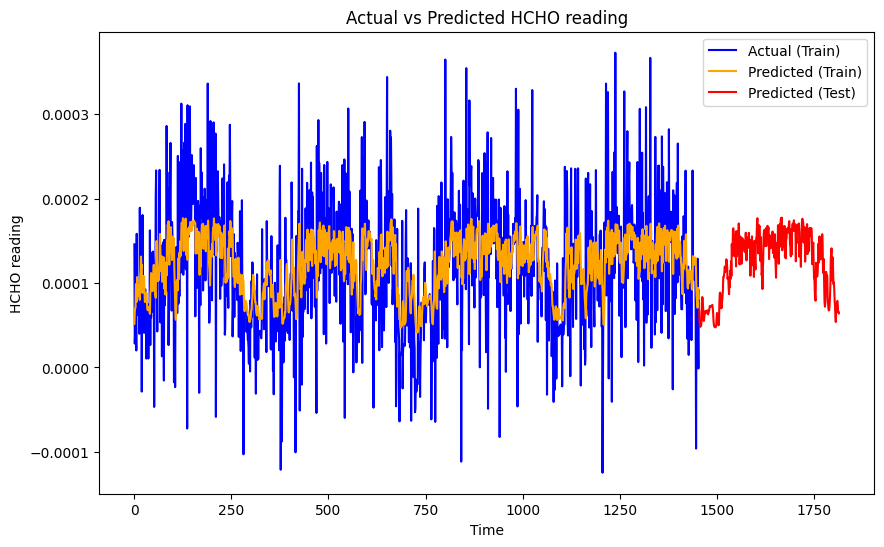

In [191]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [192]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.21748994398720056
Mean Absolute Error (MAE): 4.5849564408771375e-05
Mean Squared Error (MSE): 4.0614542705741854e-09
Root Mean Squared Error (RMSE): 6.372954001539777e-05
Median Absolute Error: 3.1377982605344714e-05
Explained Variance Score: 0.2189573575618835


21:29:04 - cmdstanpy - INFO - Chain [1] start processing
21:29:05 - cmdstanpy - INFO - Chain [1] done processing


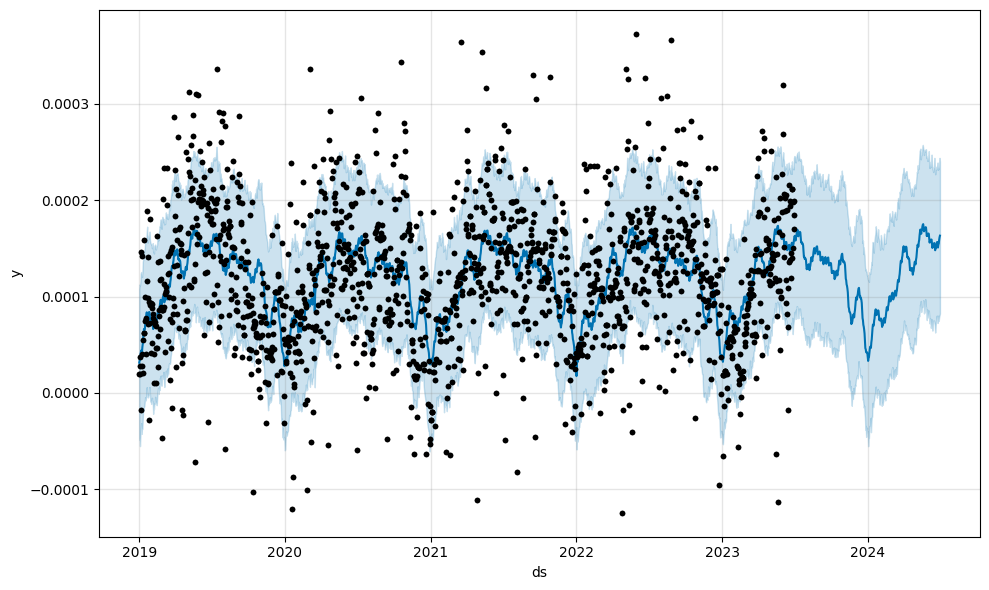

In [109]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

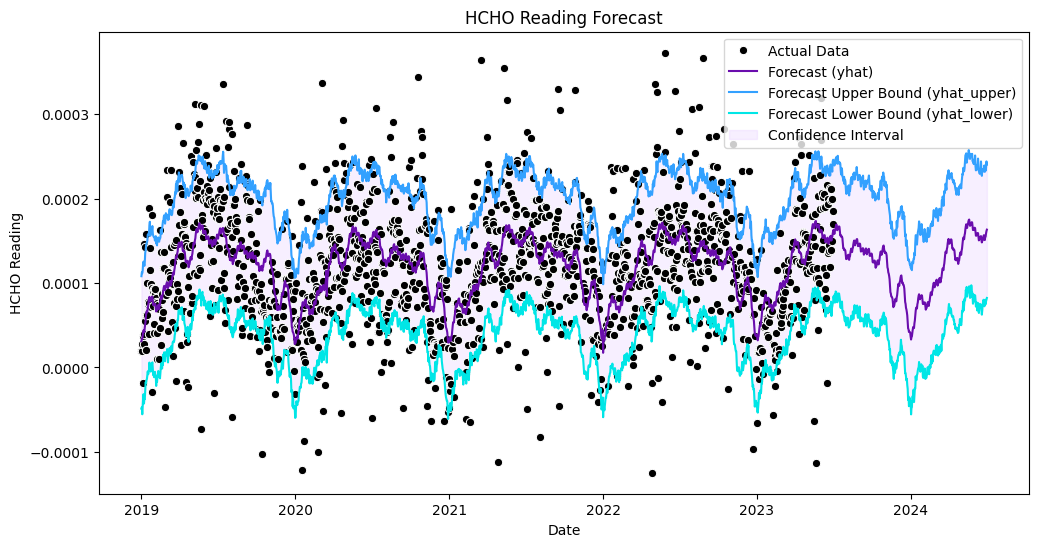

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

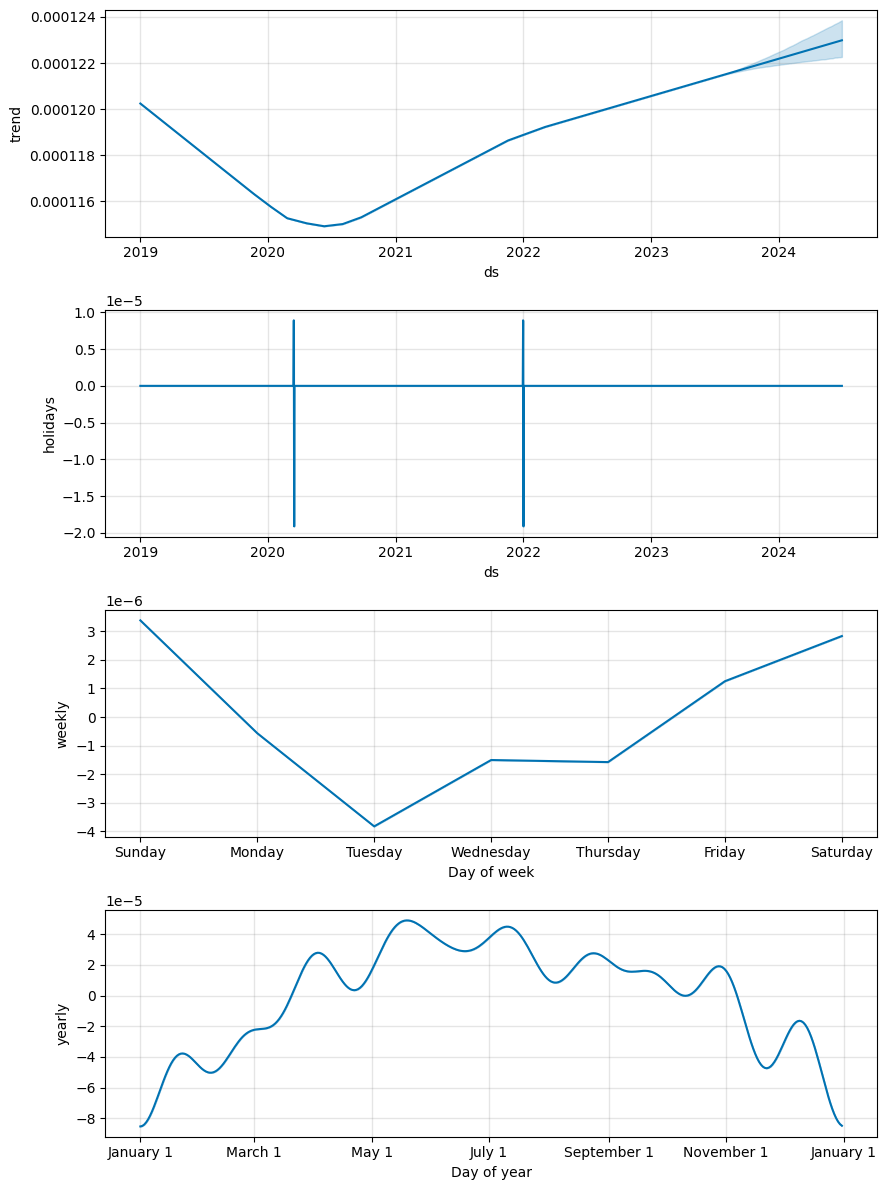

In [111]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [112]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.13282739862940995
Mean Absolute Error (MAE): 5.667339857151609e-05
Mean Squared Error (MSE): 5.321903636499948e-09
Root Mean Squared Error (RMSE): 7.295137857847478e-05
Median Absolute Error: 4.799754309937166e-05
Explained Variance Score: 0.1775401590932143
